# <a id="table-of-contents"></a>Table of Contents

1. [Moving Average](#section2)
2. [Generalized Estimating Equations](#section3)



In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import statsmodels.api as sm
import warnings
import seaborn as sns
import statsmodels.formula.api as smf
import matplotlib.colors as mcolors


from matplotlib.colors import LinearSegmentedColormap
from sklearn.model_selection import TimeSeriesSplit, KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import precision_recall_curve, confusion_matrix, mean_squared_error, r2_score, ConfusionMatrixDisplay, accuracy_score,  roc_curve, auc, average_precision_score

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.genmod.generalized_estimating_equations import GEE
from statsmodels.genmod.families import Binomial
from statsmodels.genmod.cov_struct import Autoregressive

from scipy.stats import skew, kurtosis

In [2]:
# Define the path to the Downloads folder and the file
downloads_folder = os.path.expanduser("~/Desktop")
file_name = "aaHistoricalData_1726248252859.csv" 
file_path = os.path.join(downloads_folder, file_name)

# Read the CSV file into a DataFrame
data = pd.read_csv(file_path)

In [3]:
# Convert 'Date' column to datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Sort the DataFrame by date in ascending order
data = data.sort_values(by='Date', ascending=True)

print(data.head(3))

           Date  Close/Last     Volume    Open    High     Low
2515 2014-09-15     198.981   76350030  199.16  199.32  198.38
2514 2014-09-16     200.480  116039000  198.61  200.84  198.50
2513 2014-09-17     200.750  149647200  200.77  201.68  199.75


In [4]:
# Assuming 'data' is your existing DataFrame
data['Original_Index'] = data.index  # Add the Original_Index column to capture current index
print('''It will record the INDEX to make sure that future data manipulations don't force us to lose the order.''')

It will record the INDEX to make sure that future data manipulations don't force us to lose the order.


General Desciprtive Stats 

In [5]:
# Calculate log returns for each column (Close/Last, Open, High, Low, Volume)
columns_to_calculate = ['Close/Last', 'Open', 'High', 'Low', 'Volume']
for column in columns_to_calculate:
    data[f'{column}_log_return'] = np.log(data[column] / data[column].shift(1)) * 100  # Convert to percentage

# Define columns for log returns
log_return_columns = ['Close/Last_log_return', 'Open_log_return', 'High_log_return', 'Low_log_return', 'Volume_log_return']

# Drop NaN values that result from log_return()
clean_data_close = data['Close/Last_log_return'].dropna()
clean_data_open = data['Open_log_return'].dropna()
clean_data_high = data['High_log_return'].dropna()
clean_data_low = data['Low_log_return'].dropna()
clean_data_volume = data['Volume_log_return'].dropna()

# Calculate standard deviation, mean, median, skewness, and kurtosis for Log Returns
std_dev_close = clean_data_close.std()
mean_close = clean_data_close.mean()
median_close = clean_data_close.median()
skew_close = skew(clean_data_close)
kurt_close = kurtosis(clean_data_close)

std_dev_open = clean_data_open.std()
mean_open = clean_data_open.mean()
median_open = clean_data_open.median()
skew_open = skew(clean_data_open)
kurt_open = kurtosis(clean_data_open)

std_dev_high = clean_data_high.std()
mean_high = clean_data_high.mean()
median_high = clean_data_high.median()
skew_high = skew(clean_data_high)
kurt_high = kurtosis(clean_data_high)

std_dev_low = clean_data_low.std()
mean_low = clean_data_low.mean()
median_low = clean_data_low.median()
skew_low = skew(clean_data_low)
kurt_low = kurtosis(clean_data_low)

std_dev_volume = clean_data_volume.std()
mean_volume = clean_data_volume.mean()
median_volume = clean_data_volume.median()
skew_volume = skew(clean_data_volume)
kurt_volume = kurtosis(clean_data_volume)


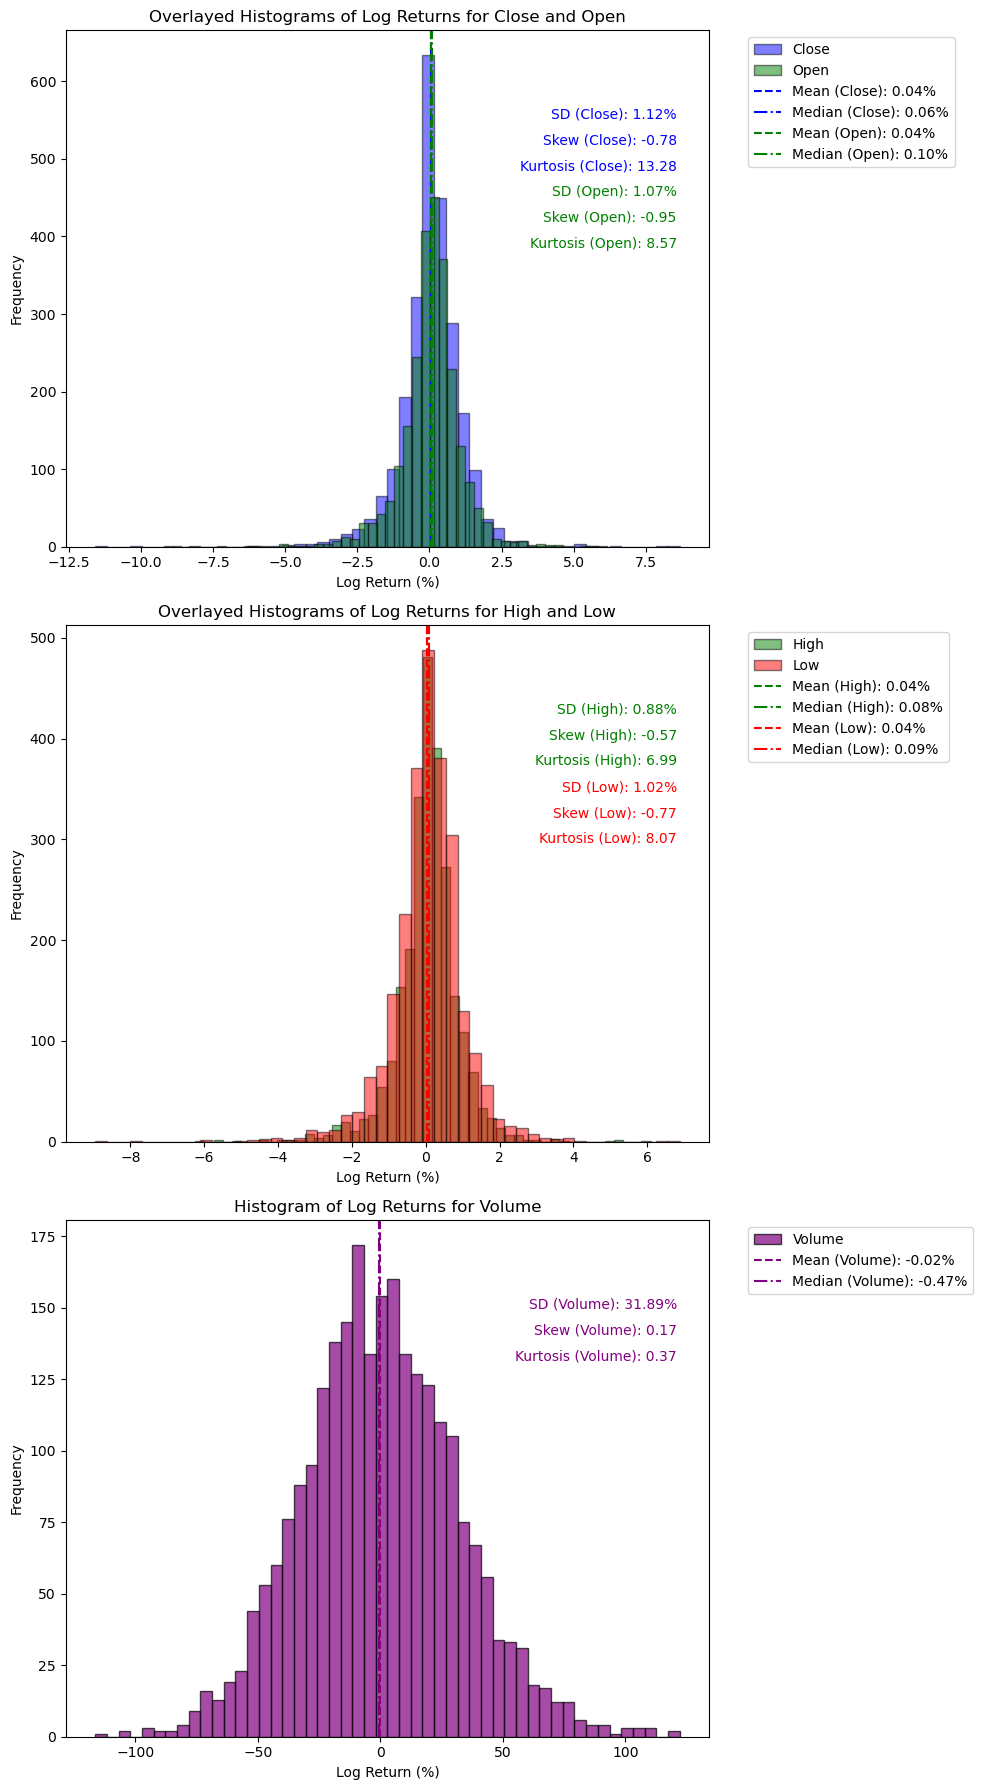


You can use the kurtosis and skewness of the disitrbution as features in the logistic regression
if you don't know the underlying causes.

the price history conforming somewhat to a logistic normal distirbution provides some comfort on using a log model going forward. 





In [6]:
# Set up the figure for the overlapping histograms
fig, axes = plt.subplots(3, 1, figsize=(10, 18), tight_layout=True)

# Drop NaN values that result from log_return()
clean_data_close = data['Close/Last_log_return'].dropna()
clean_data_open = data['Open_log_return'].dropna()
clean_data_high = data['High_log_return'].dropna()
clean_data_low = data['Low_log_return'].dropna()
clean_data_volume = data['Volume_log_return'].dropna()

# Calculate standard deviation, mean, median, skewness, and kurtosis for Log Returns
std_dev_close = clean_data_close.std()
mean_close = clean_data_close.mean()
median_close = clean_data_close.median()
skew_close = skew(clean_data_close)
kurt_close = kurtosis(clean_data_close)

std_dev_open = clean_data_open.std()
mean_open = clean_data_open.mean()
median_open = clean_data_open.median()
skew_open = skew(clean_data_open)
kurt_open = kurtosis(clean_data_open)

std_dev_high = clean_data_high.std()
mean_high = clean_data_high.mean()
median_high = clean_data_high.median()
skew_high = skew(clean_data_high)
kurt_high = kurtosis(clean_data_high)

std_dev_low = clean_data_low.std()
mean_low = clean_data_low.mean()
median_low = clean_data_low.median()
skew_low = skew(clean_data_low)
kurt_low = kurtosis(clean_data_low)

std_dev_volume = clean_data_volume.std()
mean_volume = clean_data_volume.mean()
median_volume = clean_data_volume.median()
skew_volume = skew(clean_data_volume)
kurt_volume = kurtosis(clean_data_volume)

# Plot histograms for Close and Open (overlaid)
axes[0].hist(clean_data_close, bins=50, color='blue', alpha=0.5, label='Close', edgecolor='black')
axes[0].hist(clean_data_open, bins=50, color='green', alpha=0.5, label='Open', edgecolor='black')

# Add mean, median lines, standard deviation, skewness, and kurtosis text for Close and Open
axes[0].axvline(mean_close, color='blue', linestyle='--', label=f'Mean (Close): {mean_close:.2f}%')
axes[0].axvline(median_close, color='blue', linestyle='-.', label=f'Median (Close): {median_close:.2f}%')
axes[0].text(0.95, 0.85, f'SD (Close): {std_dev_close:.2f}%', horizontalalignment='right', verticalalignment='top', transform=axes[0].transAxes, color='blue')
axes[0].text(0.95, 0.80, f'Skew (Close): {skew_close:.2f}', horizontalalignment='right', verticalalignment='top', transform=axes[0].transAxes, color='blue')
axes[0].text(0.95, 0.75, f'Kurtosis (Close): {kurt_close:.2f}', horizontalalignment='right', verticalalignment='top', transform=axes[0].transAxes, color='blue')

axes[0].axvline(mean_open, color='green', linestyle='--', label=f'Mean (Open): {mean_open:.2f}%')
axes[0].axvline(median_open, color='green', linestyle='-.', label=f'Median (Open): {median_open:.2f}%')
axes[0].text(0.95, 0.70, f'SD (Open): {std_dev_open:.2f}%', horizontalalignment='right', verticalalignment='top', transform=axes[0].transAxes, color='green')
axes[0].text(0.95, 0.65, f'Skew (Open): {skew_open:.2f}', horizontalalignment='right', verticalalignment='top', transform=axes[0].transAxes, color='green')
axes[0].text(0.95, 0.60, f'Kurtosis (Open): {kurt_open:.2f}', horizontalalignment='right', verticalalignment='top', transform=axes[0].transAxes, color='green')

# Title, labels, and legend for Close and Open plot
axes[0].set_title('Overlayed Histograms of Log Returns for Close and Open')
axes[0].set_xlabel('Log Return (%)')
axes[0].set_ylabel('Frequency')
axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Place legend outside

# Plot histograms for High and Low (overlaid)
axes[1].hist(clean_data_high, bins=50, color='green', alpha=0.5, label='High', edgecolor='black')
axes[1].hist(clean_data_low, bins=50, color='red', alpha=0.5, label='Low', edgecolor='black')

# Add mean, median lines, standard deviation, skewness, and kurtosis text for High and Low
axes[1].axvline(mean_high, color='green', linestyle='--', label=f'Mean (High): {mean_high:.2f}%')
axes[1].axvline(median_high, color='green', linestyle='-.', label=f'Median (High): {median_high:.2f}%')
axes[1].text(0.95, 0.85, f'SD (High): {std_dev_high:.2f}%', horizontalalignment='right', verticalalignment='top', transform=axes[1].transAxes, color='green')
axes[1].text(0.95, 0.80, f'Skew (High): {skew_high:.2f}', horizontalalignment='right', verticalalignment='top', transform=axes[1].transAxes, color='green')
axes[1].text(0.95, 0.75, f'Kurtosis (High): {kurt_high:.2f}', horizontalalignment='right', verticalalignment='top', transform=axes[1].transAxes, color='green')

axes[1].axvline(mean_low, color='red', linestyle='--', label=f'Mean (Low): {mean_low:.2f}%')
axes[1].axvline(median_low, color='red', linestyle='-.', label=f'Median (Low): {median_low:.2f}%')
axes[1].text(0.95, 0.70, f'SD (Low): {std_dev_low:.2f}%', horizontalalignment='right', verticalalignment='top', transform=axes[1].transAxes, color='red')
axes[1].text(0.95, 0.65, f'Skew (Low): {skew_low:.2f}', horizontalalignment='right', verticalalignment='top', transform=axes[1].transAxes, color='red')
axes[1].text(0.95, 0.60, f'Kurtosis (Low): {kurt_low:.2f}', horizontalalignment='right', verticalalignment='top', transform=axes[1].transAxes, color='red')

# Title, labels, and legend for High and Low plot
axes[1].set_title('Overlayed Histograms of Log Returns for High and Low')
axes[1].set_xlabel('Log Return (%)')
axes[1].set_ylabel('Frequency')
axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Place legend outside

# Plot histogram for Volume
axes[2].hist(clean_data_volume, bins=50, color='purple', alpha=0.7, label='Volume', edgecolor='black')

# Add mean, median lines, standard deviation, skewness, and kurtosis text for Volume
axes[2].axvline(mean_volume, color='purple', linestyle='--', label=f'Mean (Volume): {mean_volume:.2f}%')
axes[2].axvline(median_volume, color='purple', linestyle='-.', label=f'Median (Volume): {median_volume:.2f}%')
axes[2].text(0.95, 0.85, f'SD (Volume): {std_dev_volume:.2f}%', horizontalalignment='right', verticalalignment='top', transform=axes[2].transAxes, color='purple')
axes[2].text(0.95, 0.80, f'Skew (Volume): {skew_volume:.2f}', horizontalalignment='right', verticalalignment='top', transform=axes[2].transAxes, color='purple')
axes[2].text(0.95, 0.75, f'Kurtosis (Volume): {kurt_volume:.2f}', horizontalalignment='right', verticalalignment='top', transform=axes[2].transAxes, color='purple')

# Title, labels, and legend for Volume plot
axes[2].set_title('Histogram of Log Returns for Volume')
axes[2].set_xlabel('Log Return (%)')
axes[2].set_ylabel('Frequency')
axes[2].legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Place legend outside

# Show the plot
plt.show()

print('''
You can use the kurtosis and skewness of the disitrbution as features in the logistic regression
if you don't know the underlying causes.

the price history conforming somewhat to a logistic normal distirbution provides some comfort on using a log model going forward. 


''')


In [7]:
# Assuming 'data' is your DataFrame
data['day_change_abs'] = data['Close/Last'] - data['Open']

# Logistic regression preparation: Convert 'day_change_abs' to binary and create a new column 'day_change_abs_binary' (0 for Down, 1 for Up)
data['day_change_abs_binary'] = data['day_change_abs'].apply(lambda x: 1 if x > 0 else 0)

# Create moving averages in a separate DataFrame with the desired naming convention
moving_averages = pd.DataFrame()
binary_variables = pd.DataFrame()

for i in range(1, 51):
    ma_column_value = f'MA_{i}'
    binary_column = f'open_above_MA_{i}'

    # Calculate the moving average and create the binary variable
    moving_averages[ma_column_value] = data['Close/Last'].shift(1).rolling(window=i).mean()
    binary_variables[binary_column] = (data['Open'] > moving_averages[ma_column_value]).astype(int)

# Concatenate the original data, moving_averages, and binary_variables
data = pd.concat([data, moving_averages, binary_variables], axis=1)

# Drop all rows with NaN values
data.dropna(inplace=True)

# Set display option to show all columns
pd.set_option('display.max_columns', None)

data.head(1)

,Date,Close/Last,Volume,Open,High,Low,Original_Index,Close/Last_log_return,Open_log_return,High_log_return,Low_log_return,Volume_log_return,day_change_abs,day_change_abs_binary,MA_1,MA_2,MA_3,MA_4,MA_5,MA_6,MA_7,MA_8,MA_9,MA_10,MA_11,MA_12,MA_13,MA_14,MA_15,MA_16,MA_17,MA_18,MA_19,MA_20,MA_21,MA_22,MA_23,MA_24,MA_25,MA_26,MA_27,MA_28,MA_29,MA_30,MA_31,MA_32,MA_33,MA_34,MA_35,MA_36,MA_37,MA_38,MA_39,MA_40,MA_41,MA_42,MA_43,MA_44,MA_45,MA_46,MA_47,MA_48,MA_49,MA_50,open_above_MA_1,open_above_MA_2,open_above_MA_3,open_above_MA_4,open_above_MA_5,open_above_MA_6,open_above_MA_7,open_above_MA_8,open_above_MA_9,open_above_MA_10,open_above_MA_11,open_above_MA_12,open_above_MA_13,open_above_MA_14,open_above_MA_15,open_above_MA_16,open_above_MA_17,open_above_MA_18,open_above_MA_19,open_above_MA_20,open_above_MA_21,open_above_MA_22,open_above_MA_23,open_above_MA_24,open_above_MA_25,open_above_MA_26,open_above_MA_27,open_above_MA_28,open_above_MA_29,open_above_MA_30,open_above_MA_31,open_above_MA_32,open_above_MA_33,open_above_MA_34,open_above_MA_35,open_above_MA_36,open_above_MA_37,open_above_MA_38,open_above_MA_39,open_above_MA_40,open_above_MA_41,open_above_MA_42,open_above_MA_43,open_above_MA_44,open_above_MA_45,open_above_MA_46,open_above_MA_47,open_above_MA_48,open_above_MA_49,open_above_MA_50
2465,2014-11-24,207.26,65635340,207.17,207.39,206.91,2465,0.280234,-0.22661,-0.218913,0.450484,-77.245477,0.09,1,206.68,206.13,205.826667,205.7575,205.48,205.273333,205.118571,204.97375,204.885,204.7945,204.662273,204.53625,204.367308,204.131786,203.974333,203.829688,203.567941,203.264722,203.009211,202.66675,202.369762,202.031591,201.625435,201.310625,200.8702,200.393269,199.870185,199.390179,198.987069,198.601163,198.341126,198.166091,198.119845,197.976909,197.928711,197.889581,197.794727,197.704076,197.686536,197.682873,197.688168,197.656069,197.700347,197.707384,197.739442,197.803802,197.889253,197.948852,198.000508,198.020118,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


## <a id="section2"></a> Moving Averages: Logistic Regression (No GEE)

/var/folders/3v/cffbrkr510z708th2gtn8s600000gn/T/ipykernel_38354/124967402.py:104: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(color_mapper)


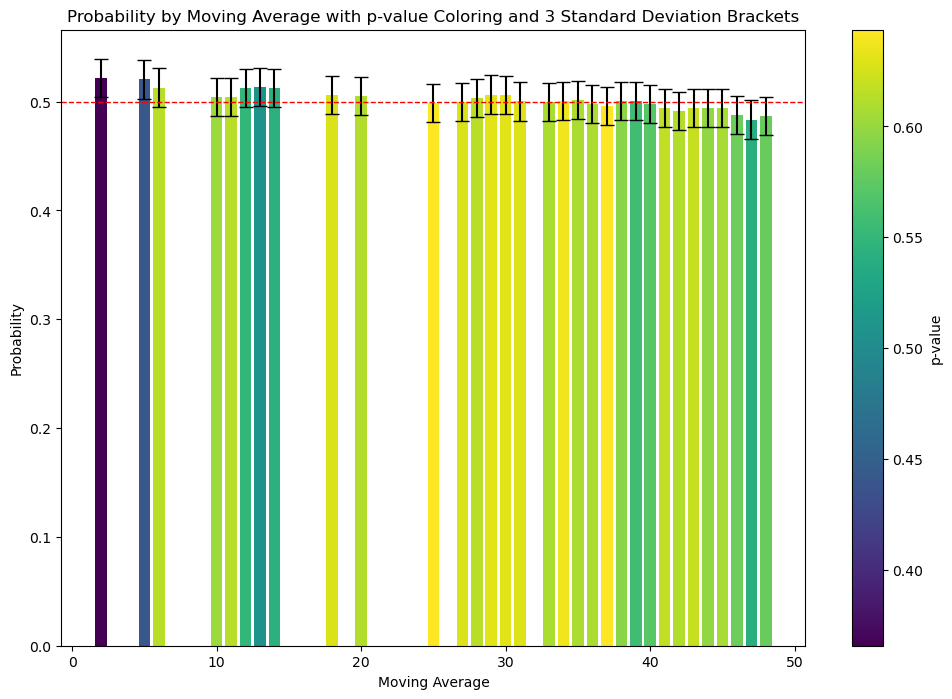


You're correct that multicollinearity is not a concern when using a single moving average as the predictor. Your approach to isolate and select the most 
predictive moving average is sound.



In [8]:
# Suppress specific FutureWarning from statsmodels globally
import warnings
warnings.filterwarnings('ignore', category=FutureWarning, message=".*grid=True will become default in a future version.*")

# Use the prepared `data` DataFrame as `clean_data`
clean_data = data.copy()

# Number of folds for cross-validation
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Prepare a list to collect results
results_list = []

# Loop over each moving average from 2 to 50 days
for i in range(2, 51):
    ma_column = f'open_above_MA_{i}'
    if ma_column in clean_data.columns:
        X = clean_data[[ma_column]]
        y = clean_data['day_change_abs_binary']
        
        # Add a constant term to the predictor
        X = sm.add_constant(X)
        
        fold_results = []
        
        # Perform k-fold cross-validation
        for train_index, test_index in kf.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            
            # Fit the logistic regression model using robust standard errors
            model = sm.Logit(y_train, X_train)
            result = model.fit(disp=0, cov_type='HC3')  # Use 'HC3' for robust standard errors
            
            # Predict on the test set
            y_pred = result.predict(X_test)
            
            # Calculate residuals for the test set
            residuals = y_test - y_pred
            
            # Calculate metrics for the test set
            coef = result.params[ma_column]
            p_value = result.pvalues[ma_column]
            odds_ratio = np.exp(coef)
            prob = odds_ratio / (1 + odds_ratio)
            
            fold_results.append({
                'Coefficient': coef,
                'p-value': p_value,
                'Odds Ratio': odds_ratio,
                'Probability': prob,
                'Residuals': residuals
            })
        
        # Average the results over all folds
        avg_result = {
            'Moving Average': i,
            'Coefficient': np.mean([r['Coefficient'] for r in fold_results]),
            'p-value': np.mean([r['p-value'] for r in fold_results]),
            'Odds Ratio': np.mean([r['Odds Ratio'] for r in fold_results]),
            'Probability': np.mean([r['Probability'] for r in fold_results]),
            'Residuals': np.concatenate([r['Residuals'] for r in fold_results])
        }
        
        # Only collect significant results with |beta| > 0.6 and p-value < 0.05
        if avg_result['p-value'] < 0.65:
            results_list.append(avg_result)

# Convert results list to a DataFrame
results_summary = pd.DataFrame(results_list)

# Calculate confidence intervals for probabilities
results_summary['Probability Lower Bound'] = results_summary['Probability'] - 1.96 * results_summary['Probability'].std()
results_summary['Probability Upper Bound'] = results_summary['Probability'] + 1.96 * results_summary['Probability'].std()

# Sort results by coefficient for better readability
results_summary_sorted = results_summary.sort_values(by='Coefficient', ascending=False)



# Create a colormap based on p-values
norm = plt.Normalize(vmin=results_summary_sorted['p-value'].min(), vmax=results_summary_sorted['p-value'].max())
colors = plt.cm.viridis(norm(results_summary_sorted['p-value']))

# Plot histogram with colors based on p-values
plt.figure(figsize=(12, 8))
bars = plt.bar(
    results_summary_sorted['Moving Average'],
    results_summary_sorted['Probability'],
    yerr=[results_summary_sorted['Probability'] - results_summary_sorted['Probability Lower Bound'],
          results_summary_sorted['Probability Upper Bound'] - results_summary_sorted['Probability']],
    capsize=5,
    color=colors
)


# Adding a red dotted line at y=0.5
plt.axhline(y=0.5, color='red', linestyle='--', linewidth=1)

# Use a descriptive name for ScalarMappable
color_mapper = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
color_mapper.set_array([])  # Needed to make the colorbar work
cbar = plt.colorbar(color_mapper)
cbar.set_label('p-value')

# Add axis labels and title
plt.xlabel('Moving Average')
plt.ylabel('Probability')
plt.title('Probability by Moving Average with p-value Coloring and 3 Standard Deviation Brackets')

# Show the plot
plt.show()


print('''
You're correct that multicollinearity is not a concern when using a single moving average as the predictor. Your approach to isolate and select the most 
predictive moving average is sound.
''')



In [9]:
# Outcome variable: next‐day price change
data['day1_change'] = (
    data['Close/Last'].shift(-1) - data['Open'].shift(-1)
) > 0
data['day1_change'] = data['day1_change'].astype(int)

crossover_pairs = [(5, 14), (5, 20), (5, 50), (14, 50), (20, 50)]
results = []

for fast, slow in crossover_pairs:
    fcol = f'MA_{fast}'
    scol = f'MA_{slow}'
    
    # 1) compute moving averages
    data[fcol] = data['Close/Last'].rolling(fast).mean()
    data[scol] = data['Close/Last'].rolling(slow).mean()
    
    # 2) direction‐specific crossovers
    bullish_col = f'bull_up_{fast}_{slow}'
    bearish_col = f'bull_down_{fast}_{slow}'
    
    data[bullish_col] = (
        (data[fcol] > data[scol]) &
        (data[fcol].shift(1) <= data[scol].shift(1))
    ).astype(int)
    
    data[bearish_col] = (
        (data[fcol] < data[scol]) &
        (data[fcol].shift(1) >= data[scol].shift(1))
    ).astype(int)
    
    # 3) drop NaNs
    mdl = data[[bullish_col, bearish_col, 'day1_change']].dropna()
    
    # for each direction, run a separate logit
    for direction, col in [('bullish', bullish_col), ('bearish', bearish_col)]:
        # skip if no events of that type
        if mdl[col].sum() == 0:
            continue
        
        X = sm.add_constant(mdl[col])
        y = mdl['day1_change']
        
        fit = sm.Logit(y, X).fit(disp=0, cov_type='HC3')
        β1 = fit.params[col]
        ci_low, ci_high = fit.conf_int().loc[col]
        
        results.append({
            'Pair':          f'{fast}/{slow}',
            'Signal Type':   direction,
            'Count':         int(mdl[col].sum()),
            'β1':            β1,
            'p-value':       fit.pvalues[col],
            'Odds Ratio':    np.exp(β1),
            'P(if signal)':  1 / (1 + np.exp(-(fit.params['const'] + β1))),
            'CI lower':      1 / (1 + np.exp(-(fit.params['const'] + ci_low))),
            'CI upper':      1 / (1 + np.exp(-(fit.params['const'] + ci_high)))
        })

# assemble and sort
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(['p-value','Pair','Signal Type'], ascending=[True,True,False])
print(results_df)


    Pair Signal Type  Count        β1   p-value  Odds Ratio  P(if signal)  \
4   5/50     bullish     41 -0.834566  0.011908    0.434063      0.341463   
0   5/14     bullish     95  0.296549  0.166607    1.345209      0.610526   
6  14/50     bullish     30  0.535184  0.169351    1.707763      0.666667   
9  20/50     bearish     24  0.533925  0.219573    1.705615      0.666667   
2   5/20     bullish     70 -0.286789  0.237772    0.750670      0.471429   
1   5/14     bearish     95  0.250792  0.239995    1.285043      0.600000   
5   5/50     bearish     40  0.352209  0.284564    1.422205      0.625000   
8  20/50     bullish     25  0.243704  0.552500    1.275967      0.600000   
3   5/20     bearish     70  0.067283  0.782819    1.069598      0.557143   
7  14/50     bearish     29  0.043959  0.906830    1.044940      0.551724   

   CI lower  CI upper  
4  0.212955  0.498411  
0  0.507329  0.704690  
6  0.482479  0.810983  
9  0.460268  0.824271  
2  0.356513  0.589455  
1  0.496

NameError: name 'cm' is not defined

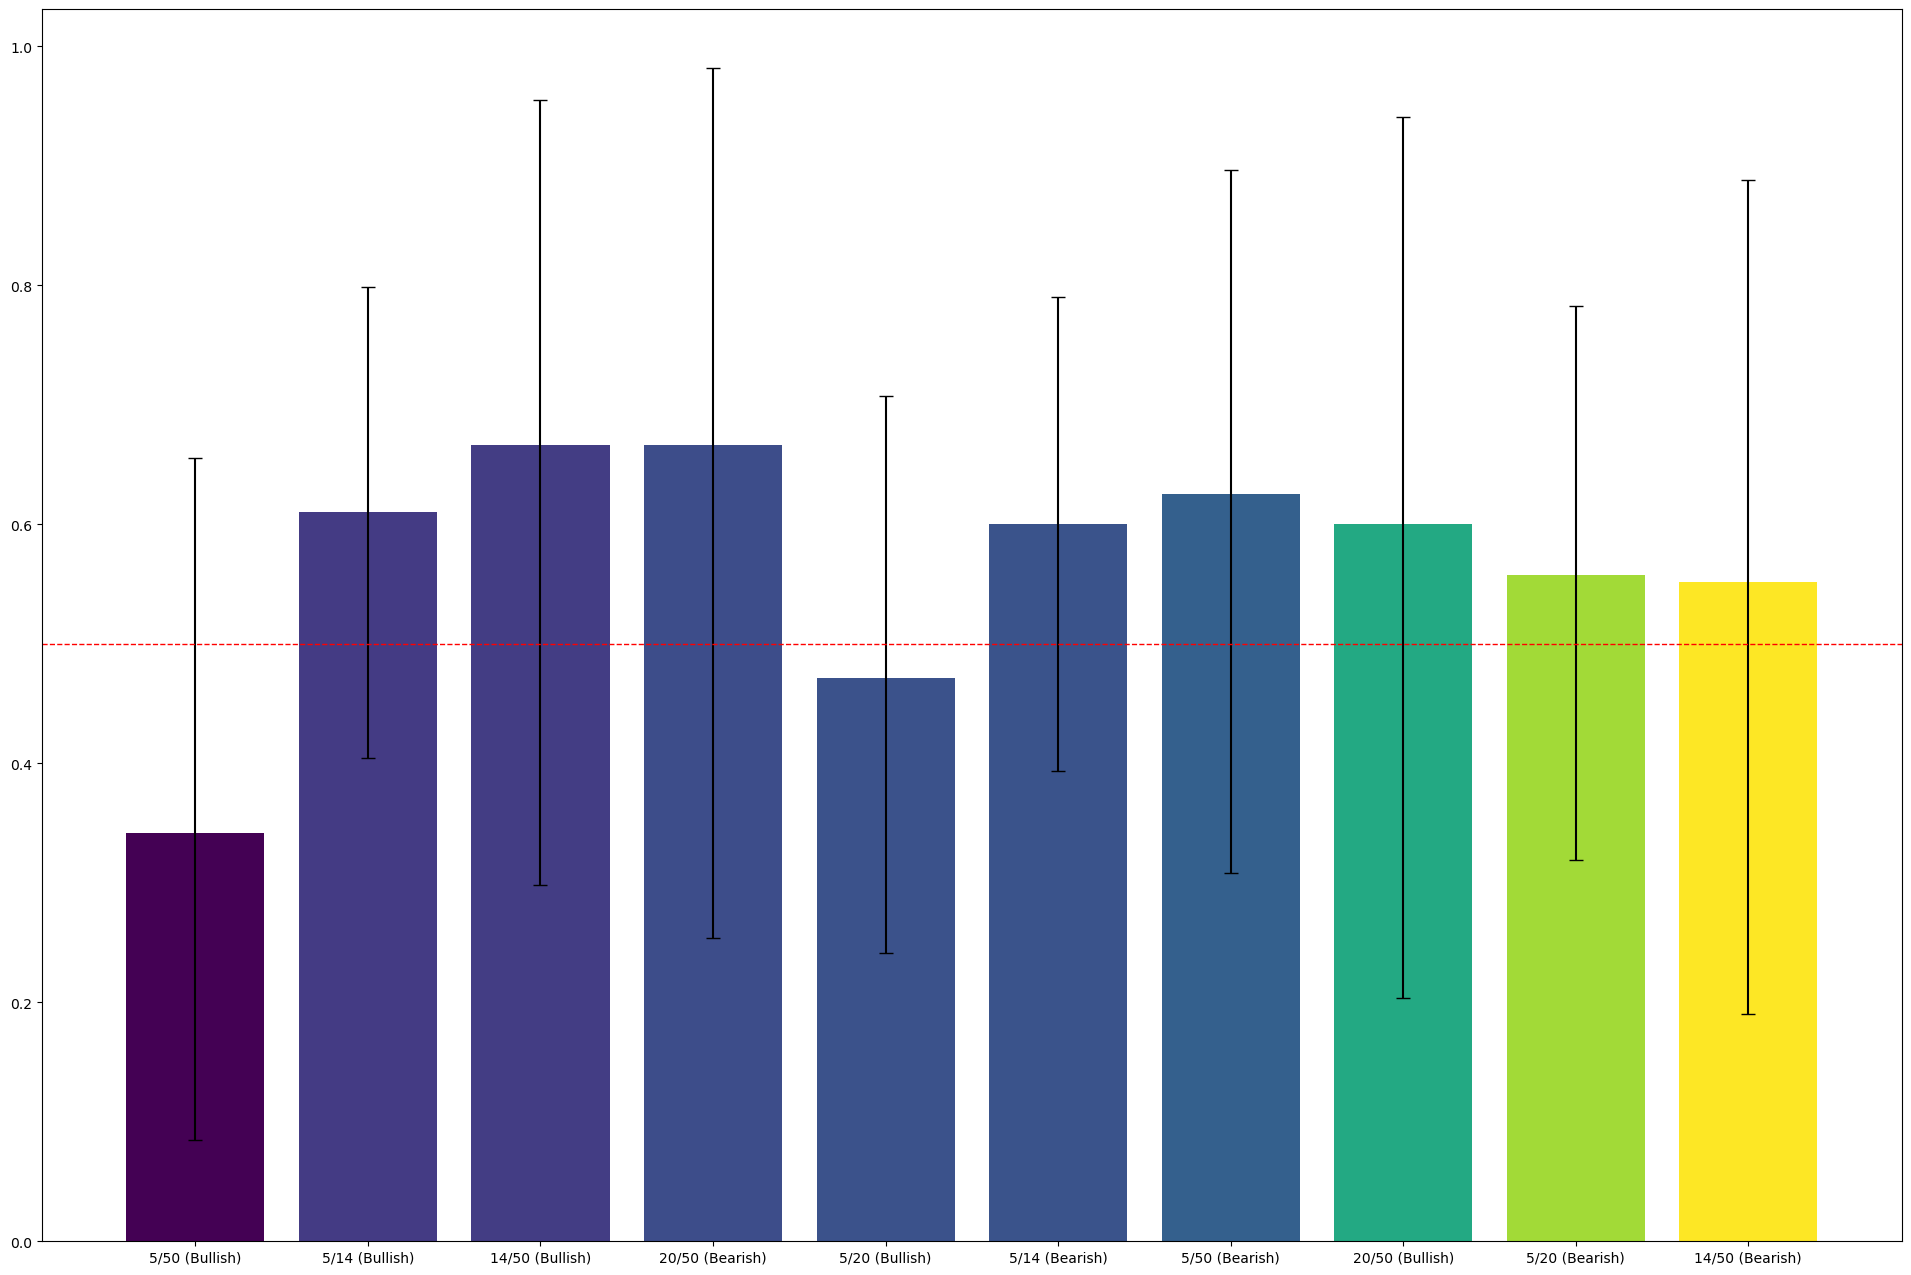

In [16]:
# Combine pair and signal type for x-axis labels
results_df['Label'] = results_df['Pair'] + ' (' + results_df['Signal Type'].str.capitalize() + ')'

# Normalize p-values for color mapping
norm = mcolors.Normalize(vmin=results_df['p-value'].min(), vmax=results_df['p-value'].max())
cmap = plt.cm.viridis
colors = cmap(norm(results_df['p-value']))

# Build the plot
plt.figure(figsize=(24, 16))
bars = plt.bar(
    results_df['Label'],
    results_df['P(if signal)'],
    yerr=[
        2 * (results_df['P(if signal)'] - results_df['CI lower']),
        2 * (results_df['CI upper'] - results_df['P(if signal)'])
    ],
    capsize=5,
    color=colors
)

# Baseline reference at 0.5 (no edge)
plt.axhline(y=0.5, color='red', linestyle='--', linewidth=1)

# Colorbar to reflect p-values
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label('p-value')

# Axis labels and title
plt.xlabel('Crossover Signal')
plt.ylabel('Estimated Probability of Up Move (Next Day)')
plt.title('Logistic Regression: Probability of Upward Return After Directional MA Crossover\nColored by p-value, with 3× CI Error Bars')

# Y-axis formatting
plt.ylim(0, 1)

# Rotate and align x-axis labels
plt.xticks(rotation=45, ha='right')

# Beautify layout
plt.tight_layout()
plt.show()


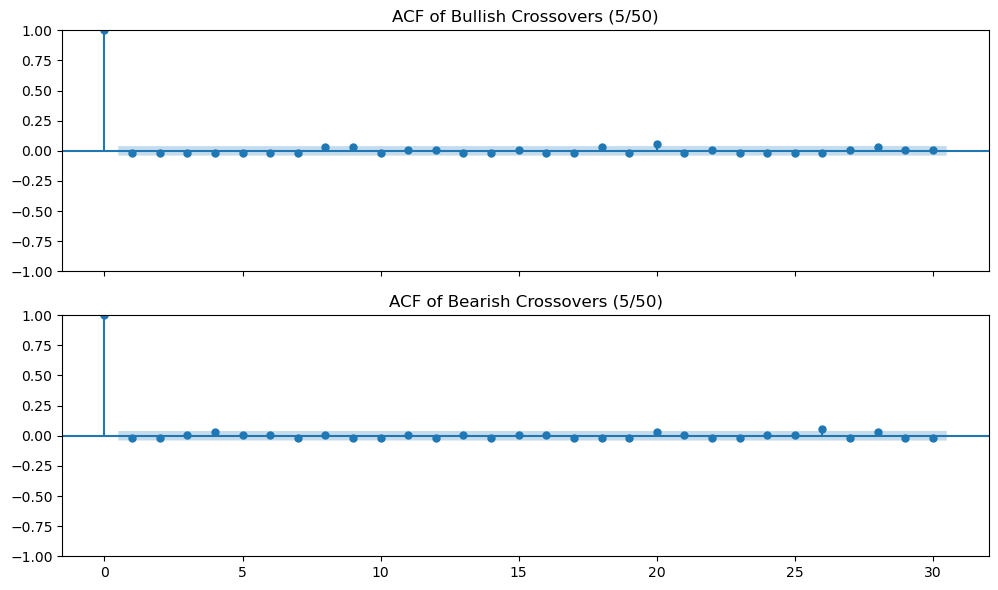

In [12]:
# Select a specific crossover pair
fast, slow = 5, 50  # You can loop through others if you like
bullish_col = f'bull_up_{fast}_{slow}'
bearish_col = f'bull_down_{fast}_{slow}'

# Drop NaNs from crossover columns
bull_series = data[bullish_col].dropna()
bear_series = data[bearish_col].dropna()

# Set up autocorrelation plot
fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

# ACF for bullish crossovers
sm.graphics.tsa.plot_acf(bull_series, lags=30, alpha=0.05, ax=axes[0])
axes[0].set_title(f'ACF of Bullish Crossovers ({fast}/{slow})')

# ACF for bearish crossovers
sm.graphics.tsa.plot_acf(bear_series, lags=30, alpha=0.05, ax=axes[1])
axes[1].set_title(f'ACF of Bearish Crossovers ({fast}/{slow})')

plt.tight_layout()
plt.show()
